In [1]:
import torch
#import nibabel as nib
#import nilearn.image as nimg
#import nilearn.plotting as nplot
import sys
import pandas as pd
import numpy as np
#import bids
from sklearn.model_selection import train_test_split
from scipy.stats import zscore

In [6]:
torch.cuda.current_device()

2

In [3]:
torch.cuda.set_device(2)

# Viewing data

In [2]:
data_dir = "/ritter/share/data/UKBB/ukb_data/bids/"
sub = "sub-1000014/ses-2/"

## Pictures

In [11]:
img = nimg.load_img(data_dir+sub+"anat/sub-1000014_ses-2_T1-brain.nii.gz")

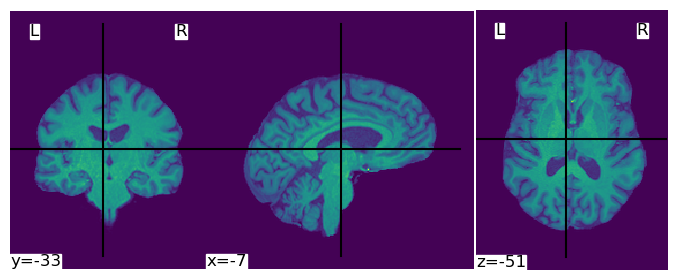

In [12]:
nplot.plot_img(img)

In [17]:
img.get_fdata().shape

(166, 228, 221)

In [13]:
func_img = nimg.load_img(data_dir+sub+"func/sub-1000014_ses-2_task-rest_filtered-clean.nii.gz")

In [15]:
# get timeseries
fdata = func_img.get_fdata()

In [16]:
fdata.shape

(88, 88, 64, 490)

In [19]:
fdata.mean(-1).shape

(88, 88, 64)

In [23]:
new_func_img = nimg.new_img_like(func_img, fdata.std(-1))

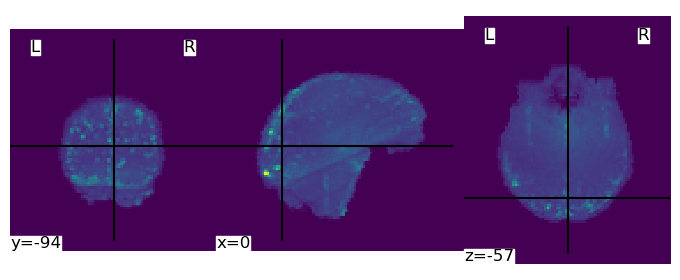

In [24]:
nplot.plot_img(new_func_img)

## Work with timeseries

In [27]:
import matplotlib.pyplot as plt

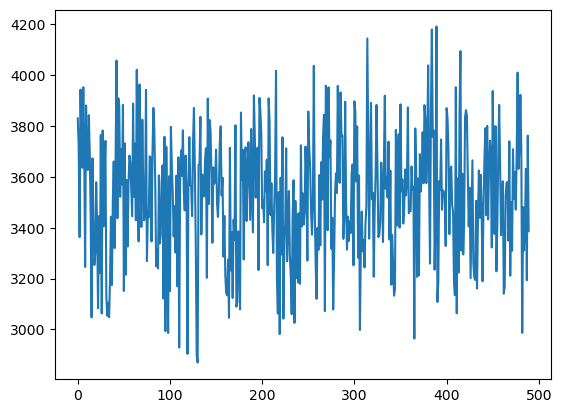

In [30]:
plt.plot(fdata[44,44,32])

In [31]:
from sklearn.decomposition import FastICA

In [32]:
ex_ica = FastICA(5)

In [33]:
X_transformed = ex_ica.fit_transform(fdata[44:54,44:54,32:42].reshape((1000,490)))

/home/laurar/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [34]:
X_transformed

array([[ 0.01856148,  0.04824472, -0.03835411, -0.02759715, -0.09667714],
       [-0.06002555,  0.03392962, -0.08252891,  0.00796291, -0.06306633],
       [ 0.00628198,  0.0009046 , -0.02773655,  0.02219373,  0.00466978],
       ...,
       [-0.00320563, -0.0249341 , -0.02095101,  0.01619531, -0.00088416],
       [-0.02741179, -0.01030109, -0.04120766, -0.01007798,  0.02301281],
       [ 0.04892375,  0.0062066 ,  0.0469619 ,  0.01140113, -0.03331732]])

In [40]:
ex_ica.components_.shape

(5, 490)

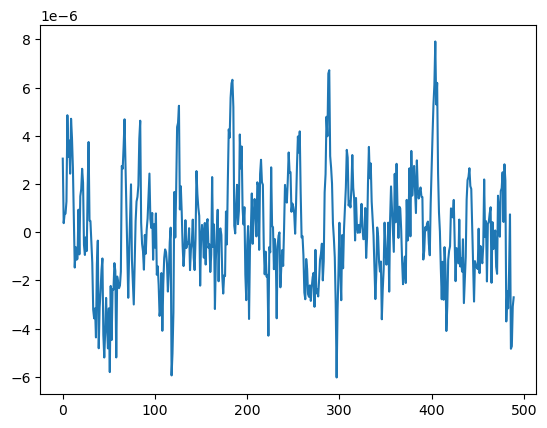

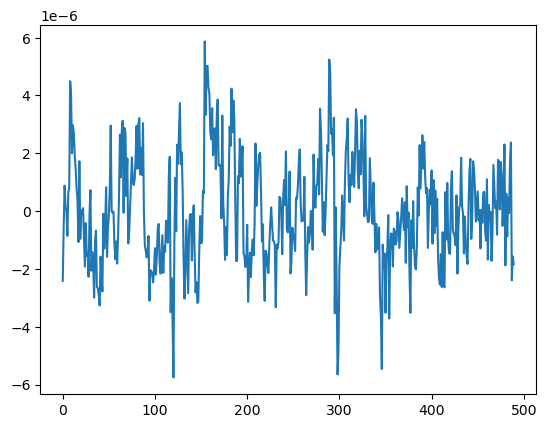

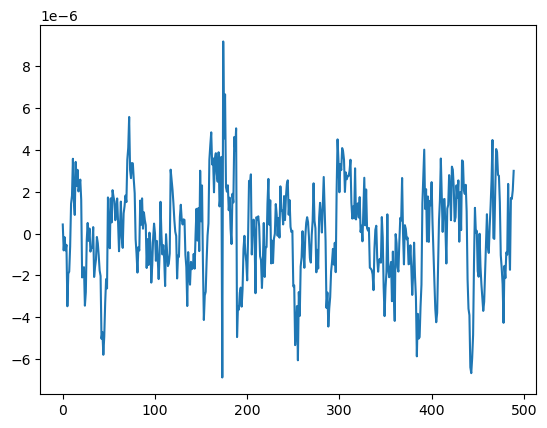

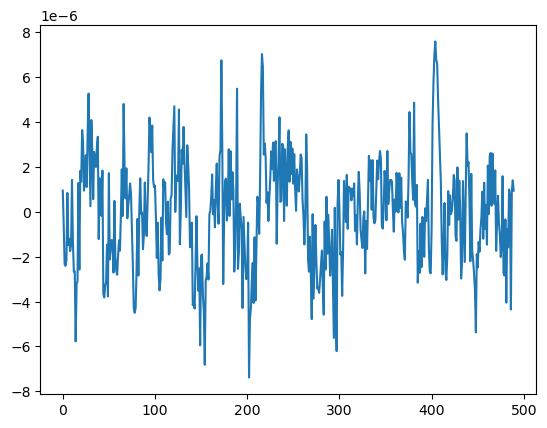

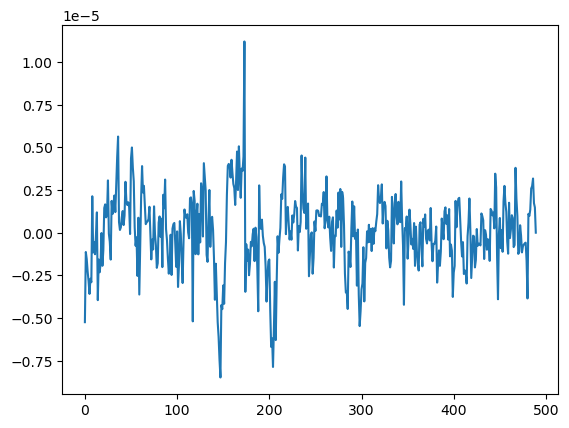

In [43]:
for component in ex_ica.components_:
    plt.figure()
    plt.plot(component)

In [46]:
ica_25 = np.loadtxt(data_dir+sub+"func/sub-1000014_ses-2_task-rest_ts-ica-25.txt")

In [48]:
ica_25.shape

(490, 25)

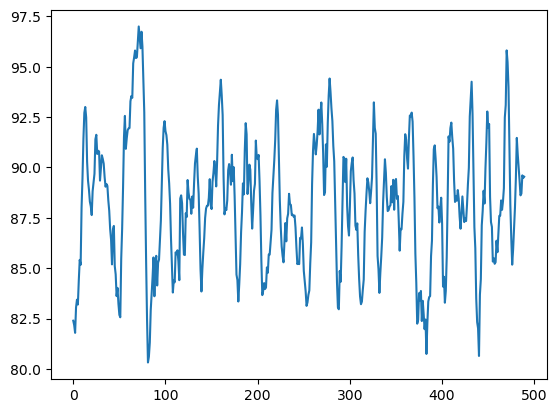

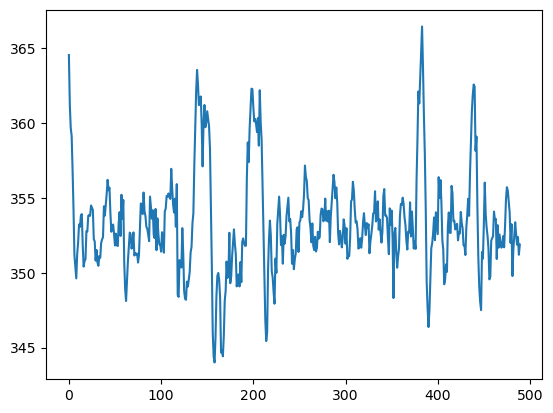

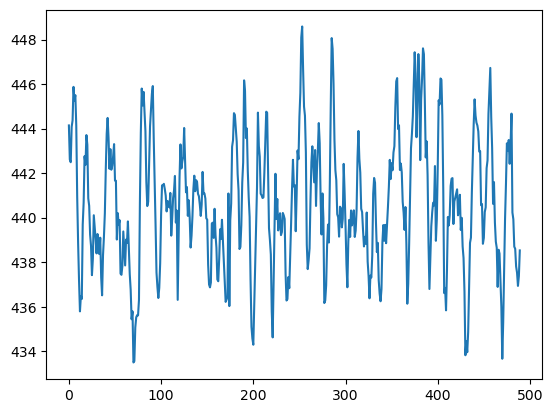

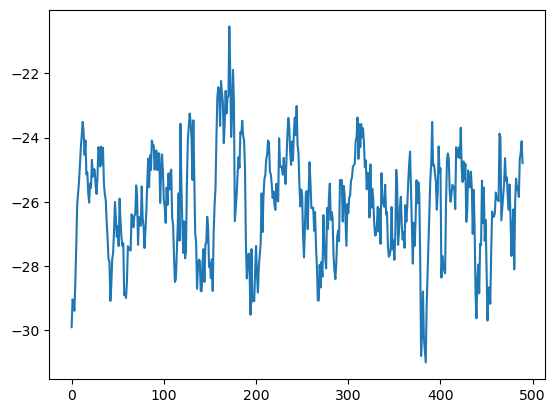

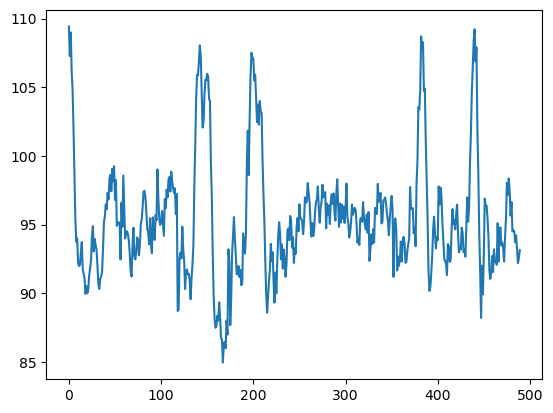

In [49]:
for ica in ica_25.T[:5]:
    plt.figure()
    plt.plot(ica)

# Loading data (effectively)

In [2]:
# prepare data paths
ukbb_dir = '/ritter/share/data/UKBB/ukb_data/'

## Metadata

In [3]:
# get target information (age)
age_df = pd.read_csv(ukbb_dir+'table/targets/age.tsv', sep='\t', names=['age'])
# get subject IDs
ids_df = pd.read_csv(ukbb_dir+'table/ukb_imaging_filtered_eids.txt')
ids_df.rename(columns={'f.eid': 'eid'}, inplace=True)
# get location of ica files
location_df = pd.read_csv(ukbb_dir+'table/files_table.csv')

# combine information
# first ids and age
meta_df = pd.concat([ids_df, age_df], axis=1)
# merge with location info based on eid
meta_df = meta_df.merge(location_df[['eid','rfmri_ica25_ts']], on='eid', how='left')
# limit df to available ICA25 data points
meta_df = meta_df[meta_df['rfmri_ica25_ts'].isna()==False]
# reset index
meta_df = meta_df.reset_index(drop=True, inplace=False)

meta_df

,eid,age,rfmri_ica25_ts
0,1000014,61,/ritter/share/data/UKBB/ukb_data/bids/sub-1000...
1,1000023,66,/ritter/share/data/UKBB/ukb_data/bids/sub-1000...
2,1000030,65,/ritter/share/data/UKBB/ukb_data/bids/sub-1000...
3,1000041,61,/ritter/share/data/UKBB/ukb_data/bids/sub-1000...
4,1000059,68,/ritter/share/data/UKBB/ukb_data/bids/sub-1000...
...,...,...,...
5897,1449303,60,/ritter/share/data/UKBB/ukb_data/bids/sub-1449...
5898,1449311,69,/ritter/share/data/UKBB/ukb_data/bids/sub-1449...
5899,1449335,61,/ritter/share/data/UKBB/ukb_data/bids/sub-1449...
5900,1449344,62,/ritter/share/data/UKBB/ukb_data/bids/sub-1449...


In [11]:
len(meta_df)

5902

In [18]:
deviants = dict()
for i in range(len(meta_df)):
    ica = np.loadtxt(meta_df.loc[i,'rfmri_ica25_ts'])
    if ica.shape != (490,25):
        deviants[i] = ica.shape[0]

In [19]:
print(f'Count of deviants: {len(deviants)}')
print(f'Min: {min(deviants.values())}')
print(f'Max: {max(deviants.values())}')

Count of deviants: 103
Min: 523
Max: 523


In [33]:
dev_test = np.loadtxt(meta_df.loc[list(deviants.keys())[0],'rfmri_ica25_ts'])

In [38]:
ttt = torch.from_numpy(dev_test)
ttt = ttt.float()

In [39]:
ttt

tensor([[ 176.1750,  349.6035,  345.6069,  ..., -157.4572,  366.6212,
          285.7179],
        [ 178.8472,  346.1882,  343.3245,  ..., -163.9764,  362.5529,
          281.6295],
        [ 180.5154,  345.2271,  341.7134,  ..., -164.6489,  361.8609,
          280.4722],
        ...,
        [ 182.3589,  346.5248,  340.4813,  ..., -166.1312,  361.3169,
          280.3849],
        [ 179.6746,  346.8494,  341.0148,  ..., -167.0310,  360.7609,
          279.0721],
        [ 174.7123,  349.1923,  343.7503,  ..., -163.9565,  361.7595,
          280.4165]])

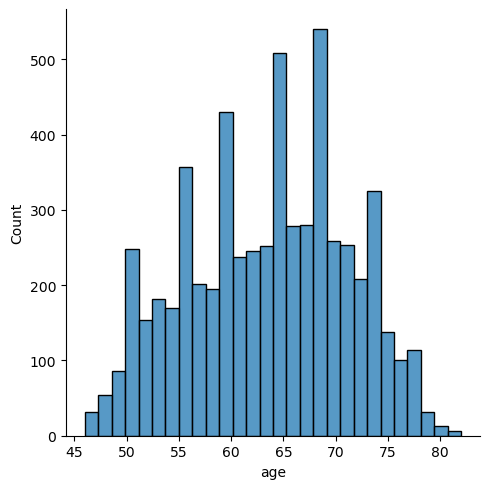

In [12]:
# visualise distribution of age
import matplotlib.pyplot as plt
import seaborn as sns
sns.displot(meta_df['age'])

In [13]:
meta_df['age'].std()

7.645498632479986

In [20]:
np.mean(abs(meta_df['age'].mean()-meta_df['age']))

6.423991729365702

In [10]:
# train/test IDs
# should I stratify for age groups??
train_id, test_id = train_test_split(meta_df['age'], test_size=0.3, random_state=43)

In [11]:
test_id.index

Int64Index([1421222, 1293684, 1043882, 1045601, 1413910, 1122709, 1364020,
            1458044, 1376343, 2089459,
            ...
            1380517, 1359394, 1136523, 1130088, 1036952, 3074759, 4037518,
            1446656, 1056734, 1093869],
           dtype='int64', name='f.eid', length=14701)

## BIDS data

In [5]:
layout = bids.BIDSLayout(ukbb_dir+'bids/', validate=False)

# getting subjects
# subs = layout.get_subjects()
subs = ['1000014', '1000023'] 

### Checking BIDS data: sessions, tasks, entities

In [5]:
layout.get_sessions()

['2']

In [6]:
layout.get_tasks()

['rest']

In [7]:
layout.get_entities()

{'subject': <Entity subject (pattern=[/\\]+sub-([a-zA-Z0-9]+), dtype=<class 'str'>)>,
 'session': <Entity session (pattern=[_/\\]+ses-([a-zA-Z0-9]+), dtype=<class 'str'>)>,
 'sample': <Entity sample (pattern=[_/\\]+sample-([a-zA-Z0-9]+), dtype=<class 'str'>)>,
 'task': <Entity task (pattern=[_/\\]+task-([a-zA-Z0-9]+), dtype=<class 'str'>)>,
 'acquisition': <Entity acquisition (pattern=[_/\\]+acq-([a-zA-Z0-9]+), dtype=<class 'str'>)>,
 'ceagent': <Entity ceagent (pattern=[_/\\]+ce-([a-zA-Z0-9]+), dtype=<class 'str'>)>,
 'staining': <Entity staining (pattern=[_/\\]+stain-([a-zA-Z0-9]+), dtype=<class 'str'>)>,
 'tracer': <Entity tracer (pattern=[_/\\]+trc-([a-zA-Z0-9]+), dtype=<class 'str'>)>,
 'reconstruction': <Entity reconstruction (pattern=[_/\\]+rec-([a-zA-Z0-9]+), dtype=<class 'str'>)>,
 'direction': <Entity direction (pattern=[_/\\]+dir-([a-zA-Z0-9]+), dtype=<class 'str'>)>,
 'run': <Entity run (pattern=[_/\\]+run-(\d+), dtype=<class 'bids.layout.utils.PaddedInt'>)>,
 'proc': <Enti

### Load BIDS data

In [8]:
# get all ica_ts file names
ica_files = layout.get(datatype='func',
                        subject=['1000014', '1000023'], # remove this line for proper analysis!
                        task='rest',
                        session='2',
                        suffix='25', # filters for ts-ica-25
                        extension='txt',
                        return_type='filename')

In [1]:
ica_files

NameError: name 'ica_files' is not defined

In [14]:
# collect normalised ts data in array
ica_ts = []
for file in ica_files:
    ts = np.loadtxt(file)
    ts = zscore(ts, axis=0)
    ica_ts.append(ts)
ica_ts = np.asarray(ica_ts)

# check shape
ica_ts.shape

(2, 490, 25)

In [30]:
ica_test = layout.get(datatype='func',
                        subject=1000014, # remove this line for proper analysis!
                        task='rest',
                        session='2',
                        suffix='25', # filters for ts-ica-25
                        extension='txt',
                        return_type='filename')

In [31]:
ica_test

['/ritter/share/data/UKBB/ukb_data/bids/sub-1000014/ses-2/func/sub-1000014_ses-2_task-rest_ts-ica-25.txt']

In [32]:
ts_test = np.loadtxt(ica_test[0])

In [23]:
ts_test

array([[ 82.39461589, 364.5531675 , 444.1430674 , ...,  -2.95535864,
        518.4273021 , 366.7859126 ],
       [ 82.17554119, 361.2234522 , 442.6131934 , ...,  -2.95041664,
        516.1525925 , 364.7467167 ],
       [ 81.79264138, 359.674711  , 442.4893809 , ...,  -3.50413124,
        516.8964224 , 366.6760743 ],
       ...,
       [ 89.60922357, 352.38267   , 436.9340105 , ..., -14.27671905,
        510.2342644 , 358.0888269 ],
       [ 89.48388624, 351.2009285 , 437.3755968 , ..., -15.03984659,
        510.9896604 , 359.1898045 ],
       [ 89.54163442, 351.8838136 , 438.5274627 , ..., -14.83852246,
        510.2104282 , 357.5267865 ]])

In [39]:
test_df = pd.concat([ids_df, age_df], axis=1)

In [40]:
for idx in [0,1,2,3]:
    print(test_df.loc[idx,'f.eid'])

1000014
1000023
1000030
1000041


In [41]:
test_id = test_df.loc[0,'f.eid']

In [46]:
torch_id = torch.tensor(test_id)

In [47]:
torch_id

tensor(1000014)

Try out which input dimension last linear layer has/needs

In [ ]:
input = torch.randn(10,25,490)
print('input size:', input.size())

 # define convolutional and maxpool layers
conv1 = nn.Conv1d(25, 32, kernel_size=5)
conv2 = nn.Conv1d(32, 64, kernel_size=5)
conv3 = nn.Conv1d(64, 128, kernel_size=5)
conv4 = nn.Conv1d(128, 256, kernel_size=5)
maxpool = nn.MaxPool1d(kernel_size=5, stride=2)
linear = nn.Linear(256,1)
flat = nn.Flatten()

activation = nn.ReLU()
loss = nn.MSELoss()
                
# define model architecture
x = conv1(input)
print(x.size())
x = activation(x)
print(x.size())
x = maxpool(x)
print('maxpool', x.size())

x = conv2(x)
print(x.size())
x = activation(x)
print(x.size())
x = maxpool(x)
print('maxpool', x.size())

x = conv3(x)
print(x.size())
x = activation(x)
print(x.size())
x = maxpool(x)
print('maxpool', x.size())

x = conv4(x)
print(x.size())
x = activation(x)
print(x.size())
x = maxpool(x)
print('final maxpool', x.size())

x = flat(x)
print('flattened', x.size())
# x = linear(x)
# print('final output size:', x.size())

In [1]:
import torch
torch.__version__

'1.13.1'

In [22]:
lr = [10e-2, 10e-3, 10e-4, 10e-5, 10e-6]
for r in lr:
    print(str(r))

0.1
0.01
0.001
0.0001
1e-05


In [23]:
str(10e-2)

'0.1'